# 3層ANNによる非線形歪補償
最も基本的な、入力層・中間層・出力層からなる3層ANNによる補償

In [1]:
#import
import sys
import os
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. Preprocessing

## 1.1 データの整形

In [2]:
def data_shaping(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(int((max_tap - 1) / 2), len(input_signal) - int((max_tap - 1) / 2))):
        x[i, 0::2] = signal[j - int((tap - 1) / 2): j + int((tap - 1) / 2) + 1].real
        x[i, 1::2] = signal[j - int((tap - 1) / 2): j + int((tap - 1) / 2) + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [3]:
#動作確認
tap = 29
max_tap = 51

df_dir = '../data/input/prbs.csv'
df = pd.read_csv(df_dir, index_col=0)  # dataframe読み込み
condition = (df['N']==13) & (df['itr']==1) & (df['form']=='RZ16QAM') & (df['n']==32) & (df['equalize']==False) & (df['baudrate']==28) & (df['PdBm']==1)
sgnl = load_pickle(df[condition].iloc[0]['data_path'])  # dataframeから条件と合う行を取得し,pickleの保存先(data_path)にアクセス
lc = sgnl.linear_compensation(500, sgnl.signal['x_500'])
x, y = data_shaping(sgnl.signal['x_0'][16::32], lc[16::32], max_tap, tap)  # ANNに入力できるようにデータを整形

print('x size: ', x.shape)
print('y size: ', y.shape)

x size:  (1998, 58)
y size:  (1998, 2)


Text(0.5, 1.0, 'constellation L=500km 100%linear comp.')

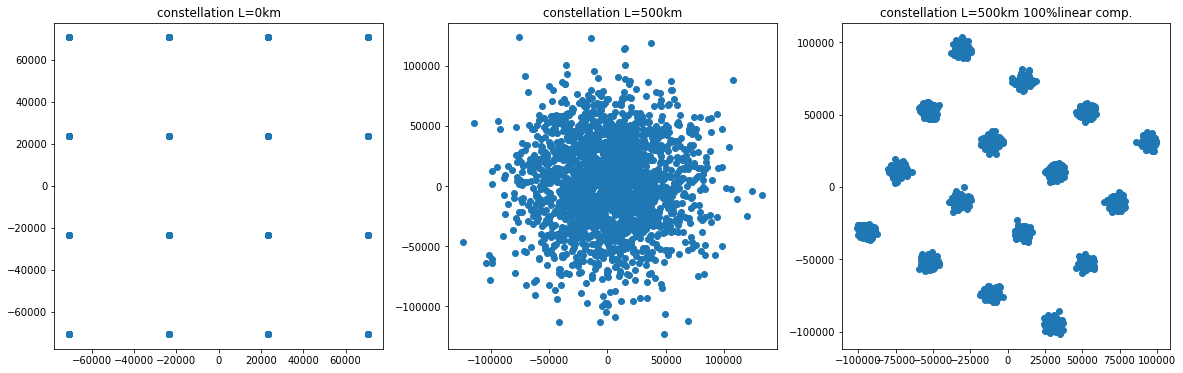

In [4]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(sgnl.signal['x_0'][16::32].real, sgnl.signal['x_0'][16::32].imag, 'o')
ax1.set_title('constellation L=0km')

ax2.plot(sgnl.signal['x_500'][16::32].real, sgnl.signal['x_500'][16::32].imag, 'o')
ax2.set_title('constellation L=500km')

ax3.plot(lc[16::32].real, lc[16::32].imag, 'o')
ax3.set_title('constellation L=500km 100%linear comp.')

## 1.2 平均,標準偏差の計算

In [5]:
mean = np.mean(x)
std = np.std(x)

print('mean: ', mean)
print('std: ', std)

mean:  1114.566034016905
std:  52135.81798093404


# 2. Dataset定義

In [6]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)

In [7]:
#動作確認
train_dataset = Dataset(x=x, y=y, mean=mean, std=std)

index = 0
x_normalized, y_normalized = train_dataset.__getitem__(index)
x_array = x_normalized.detach().numpy()

print('mean: ', np.mean(x_array))
print('std: ', np.std(x_array))
print(x_normalized)
print(y_normalized)

mean:  -0.077707395
std:  0.9639421
tensor([ 0.9693, -1.0745, -0.6699,  1.8032, -0.5759,  1.8653,  0.5698,  0.2886,
         0.1388,  1.4003,  0.5786,  0.2232, -1.5219,  0.2726, -1.4724,  0.2109,
         1.3767, -0.1905,  0.6876,  0.1550,  0.2036, -0.6009,  0.1481, -0.6349,
        -1.3982,  0.1562, -0.9955,  0.9853, -0.9983,  0.9963,  0.5785, -1.8098,
        -0.3434,  0.6310, -0.9265,  0.9492, -0.2729, -1.4374, -0.1848,  0.6101,
        -1.0056,  0.9539, -1.8427, -0.6546, -1.0626,  0.9643, -1.3433,  0.2304,
         1.8052,  0.5728,  0.9691, -0.9143, -1.8148, -0.6689, -0.6409, -0.2163,
         0.1102, -0.6393])
tensor([-1.3731,  0.4292])


In [8]:
batch_size = 100

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader}

# 3. Model定義

In [9]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
#動作確認
hidden_neuron = 300
model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron)
for x, y in train_dataloader:
    output = model(x)
    print(output[:6])
    break

tensor([[-0.0534,  0.4731],
        [-0.0349,  0.3209],
        [-0.0369,  0.2897],
        [-0.0642,  0.0655],
        [ 0.1417,  0.3511],
        [ 0.2945,  0.1977]], grad_fn=<SliceBackward>)


# 4. train定義

In [11]:
def evm_score(y_true, y_pred):
    if y_true.ndim == 2:
        y_true = y_true[:, 0] + 1j * y_true[:, 1]
        y_pred = y_pred[:, 0] + 1j * y_pred[:, 1]
    tmp = 0
    for i in range(len(y_pred)):
        tmp += abs(y_pred[i] - y_true[i]) ** 2 / abs(y_true[i]) ** 2
    evm = torch.sqrt(tmp / len(y_pred)) * 100
    return evm

In [23]:
def train_model(model, dataloaders_dict, criterion, optimizer, epochs, epochs_section=None):
    for epoch in range(epochs):
        if epochs_section is not None:
            epoch += epochs_section[0]
            end_epoch = epochs_section[1]
        else:
            end_epoch = epochs
        
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x, y in dataloaders_dict[phase]:
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x.size(0)
                    epoch_evms = (evm_score(y, outputs) / 100) ** 2 * x.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, end_epoch, phase, epoch_loss, epoch_evm))
    return model

In [21]:
#動作確認
epochs = 5
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

train_model(model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs);

0:00:05 | Epoch: 1/5 | train Loss: 0.001516 | EVM: 0.01242
0:00:05 | Epoch: 2/5 | train Loss: 0.001038 | EVM: 0.01284
0:00:05 | Epoch: 3/5 | train Loss: 0.0007038 | EVM: 0.00421
0:00:05 | Epoch: 4/5 | train Loss: 0.0004743 | EVM: 0.004792
0:00:05 | Epoch: 5/5 | train Loss: 0.0003379 | EVM: 0.01093


# 5. 実行

In [15]:
#結果を保存しない
tap = 1
max_tap = 501
batch_size = 100
hidden_neuron = 300
epochs = 5
lr = 0.001

df_dir = '../data/input/'
df0 = pd.read_csv(df_dir+'prbs.csv', index_col=0)

condition0 = (df0['N']==13) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl0 = load_pickle(df0[condition0].iloc[0]['data_path'])
lc0 = sgnl0.linear_compensation(2500, sgnl0.signal['x_2500'])
x0, y0 = data_shaping(sgnl0.signal['x_0'][16::32], lc0[16::32], max_tap, tap)

condition1 = (df0['N']==17) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl1 = load_pickle(df0[condition1].iloc[0]['data_path'])
lc1 = sgnl1.linear_compensation(2500, sgnl1.signal['x_2500'])
x1, y1 = data_shaping(sgnl1.signal['x_0'][16::32], lc1[16::32], max_tap, tap)

mean = np.mean(x0)
std = np.std(x0)

train_dataset = Dataset(x=x0, y=y0, mean=mean, std=std)
val_dataset = Dataset(x=x1, y=y1, mean=mean, std=std)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

model = train_model(model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs)

0:00:00 | Epoch: 1/5 | train Loss: 0.4788 | EVM: 4.891
0:00:02 | Epoch: 1/5 | val Loss: 0.076 | EVM: 1.235
0:00:00 | Epoch: 2/5 | train Loss: 0.03803 | EVM: 4.683
0:00:02 | Epoch: 2/5 | val Loss: 0.03747 | EVM: 1.177
0:00:00 | Epoch: 3/5 | train Loss: 0.0275 | EVM: 3.317
0:00:02 | Epoch: 3/5 | val Loss: 0.02258 | EVM: 0.9239
0:00:00 | Epoch: 4/5 | train Loss: 0.01577 | EVM: 2.54
0:00:02 | Epoch: 4/5 | val Loss: 0.01777 | EVM: 0.8082
0:00:00 | Epoch: 5/5 | train Loss: 0.01431 | EVM: 3.057
0:00:02 | Epoch: 5/5 | val Loss: 0.01714 | EVM: 0.8125


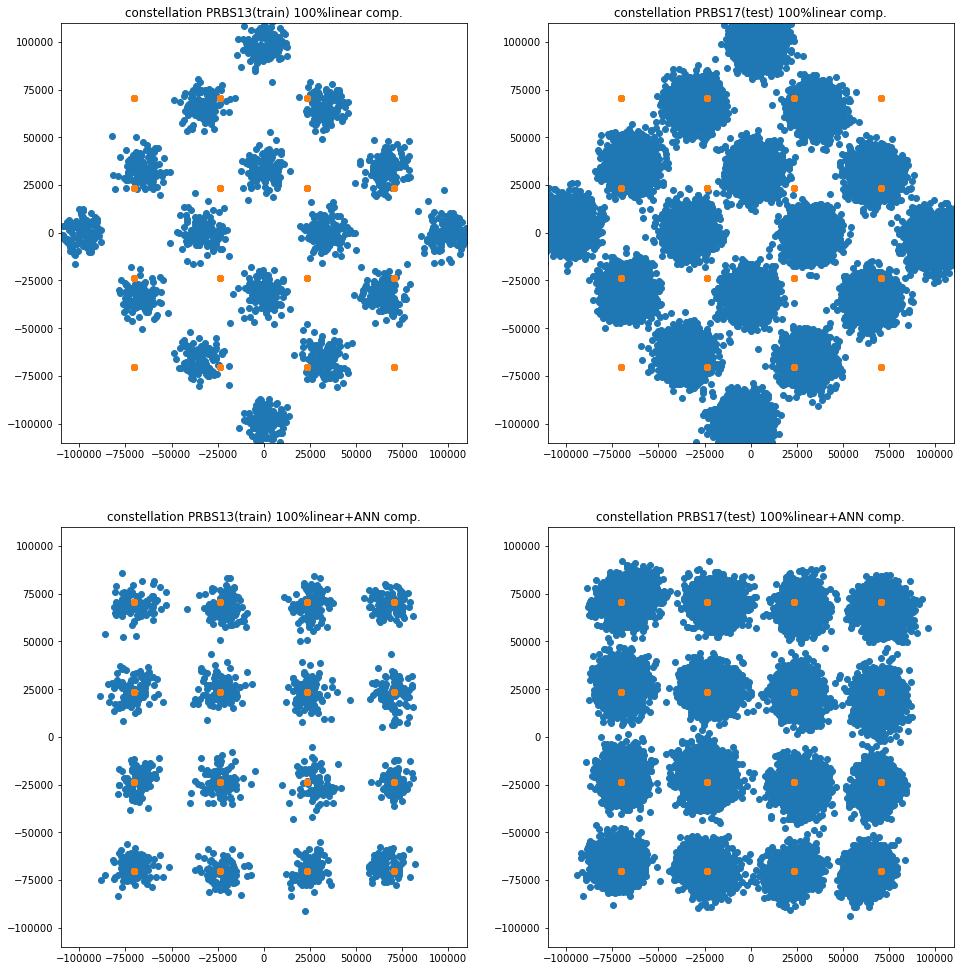

In [16]:
#可視化
annc0 = model(train_dataset[:][0]).detach().numpy()
annc0 = annc0 * std + mean
y0 = train_dataset[:][1].detach().numpy()
y0 = y0 * std + mean
annc1 = model(val_dataset[:][0]).detach().numpy()
annc1 = annc1 * std + mean
y1 = val_dataset[:][1].detach().numpy()
y1 = y1 * std + mean

lim = 110000

fig = plt.figure(figsize=(16, 17))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.plot(lc0[16::32].real, lc0[16::32].imag, 'o')
ax1.plot(y0[:, 0], y0[:, 1], 'o')
ax1.set_title('constellation PRBS13(train) 100%linear comp.')
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)
ax2.plot(lc1[16::32].real, lc1[16::32].imag, 'o')
ax2.plot(y0[:, 0], y0[:, 1], 'o')
ax2.set_title('constellation PRBS17(test) 100%linear comp.')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

ax3.plot(annc0[:, 0], annc0[:, 1], 'o')
ax3.plot(y0[:, 0], y0[:, 1], 'o')
ax3.set_title('constellation PRBS13(train) 100%linear+ANN comp.')
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)
ax4.plot(annc1[:, 0], annc1[:, 1], 'o')
ax4.plot(y1[:, 0], y1[:, 1], 'o')
ax4.set_title('constellation PRBS17(test) 100%linear+ANN comp.')
ax4.set_xlim(-lim, lim)
ax4.set_ylim(-lim, lim);

In [38]:
#結果と条件を../data/params/ANN.csvに保存する
tap = 1
max_tap = 501
batch_size = 100
neuron = 300
epochs = 100
lr = 0.001

signal_type = 'image'

form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]
Lmax = 500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

if signal_type == 'prbs':
    N = 13  # PRBSの次数
    itr = 1  # PRBSの繰り返し回数
elif signal_type == 'random':
    seed = 1234  # 乱数シード
    bit_num = 10000  # ビット長を指定
elif signal_type == 'image':
    target_dir = 'train'
    step = 10  # =10 ---> (768, 1024) ---> (76, 102)
    image_number = [0, 1]
    ebtb = True  # 8B10Bを行うか

# prbs.csv or random.csv or image.csvをpandasで読み込む
t_df_dir = '../data/input/'
t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

# if ANN.csv がある: pandasで読み込む if ANN.csvがない: 新しいDataFrameを作る
l_df_dir = '../data/params/ANN.csv'
if os.path.exists(l_df_dir):
    l_df = pd.read_csv(l_df_dir, index_col=0)
else:
    cols = ['tap', 'max_tap', 'batch_size', 'neuron', 'epochs', 'learning_rate', 'N', 'itr', 'seed', 'bit_num', 'target_dir', 'step', 'image_number', 'ebtb', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'params_path', 'train_samples']
    l_df = pd.DataFrame(index=[], columns=cols)
    l_df.to_csv(l_df_dir)

# 指定した学習条件と伝送条件
l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)
t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                        gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
if signal_type == 'prbs':
    condition = 'N=='+str(N)+'&itr=='+str(itr)
    condition_list = [N, itr] + [None] * 6
elif signal_type == 'random':
    condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    condition_list = [None] * 2 + [seed, bit_num] + [None] * 4
elif signal_type == 'image':
    condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+str(image_number[0])+'&ebtb=='+str(ebtb)
    condition_list = [None] * 4 + [target_dir, step, image_number, ebtb]

# prbs.csv or random.csv or image.csvにおいて、指定した伝送条件を見たす行を抜き出す
t_query = t_df.query(condition + '&' + t_condition)

# ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
l_query = l_df.query(l_condition + '&' + condition + '&' + t_condition + '&Lmax=='+str(Lmax))

# 後で異なる値が代入されるもの以外をSeriesにしてしまう(epochs, params_path, train_samplesだけNone)
sr = pd.Series([tap, max_tap, batch_size, neuron, None, lr] + condition_list + [form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, None, None], index=l_df.columns)
    
#if epochsを含む指定された条件を満たす結果がある: 何もしない
if len(l_query) > 0 and l_query['epochs'].max() >= epochs:
    print('指定された条件の学習結果はすでに存在します')
else:
    # if epochs以外の指定された条件を満たす結果がある: パラメータを読み込む if ない: 新しくモデルを作成する
    if len(l_query) > 0:
        index = l_query['epochs'].idxmax()
        trained_epochs = l_query['epochs'][index]
        model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron)
        model.load_state_dict(torch.load(query['params_path'][index]))
    else:
        trained_epochs = 0
        model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron)
    
    # if prbs.csv or random.csv or image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
    else:
        # 伝送信号を学習データに整形する
        sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
        lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
        x_train, y_train = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)
        
        if signal_type == 'image' and len(image_number) > 1:
            for i in range(1, len(image_number)):
                condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+str(image_number[i])+'&ebtb=='+str(ebtb)
                t_query = t_df.query(condition + '&' + t_condition)
                if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
                    print('指定された伝送条件の信号が存在しません')
                    sys.exit()
                sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
                lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
                x_train_tmp, y_train_tmp = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)
                x_train = np.concatenate([x_train, x_train_tmp])
                y_train = np.concatenate([y_train, y_train_tmp])
        
        train_samples = len(x_train)

        # 平均,標準偏差の計算
        mean = np.mean(x_train)
        std = np.std(x_train)

        # dataset, dataloaderの作成
        train_dataset = Dataset(x=x_train, y=y_train, mean=mean, std=std)
        train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        dataloaders_dict = {'train': train_dataloader}

        # 損失関数, オプティマイザの作成
        criterion = nn.MSELoss()
        optimizer = optim.Adam(params=model.parameters(), lr=lr)

        # モデルのトレーニング(50epochsずつ学習し、50epochsずつパラメータを保存する)
        for i in range((epochs - trained_epochs) // 50):
            model = train_model(model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=50, epochs_section=[trained_epochs+i*50, epochs])

            # 学習済みパラメータを保存し、ANN.csvに保存先を記入する
            l_df = pd.read_csv(l_df_dir, index_col=0)
            params_path = '../data/params/ANN/params_' + str(len(l_df)).zfill(10) + '.pth'
            torch.save(model.state_dict(), params_path)
            sr[4] = trained_epochs + (i + 1) * 50
            sr[-2] = params_path
            sr[-1] = train_samples
            l_df = l_df.append(sr, ignore_index=True)
            l_df.to_csv(l_df_dir)

l_df

0:00:11 | Epoch: 1/100 | train Loss: 0.00871 | EVM: 0.1248
0:00:11 | Epoch: 2/100 | train Loss: 0.001998 | EVM: 0.1126
0:00:11 | Epoch: 3/100 | train Loss: 0.00119 | EVM: 0.09294
0:00:11 | Epoch: 4/100 | train Loss: 0.0006847 | EVM: 0.08544
0:00:11 | Epoch: 5/100 | train Loss: 0.0003704 | EVM: 0.05471
0:00:11 | Epoch: 6/100 | train Loss: 0.0002044 | EVM: 0.04112
0:00:11 | Epoch: 7/100 | train Loss: 0.0001184 | EVM: 0.02944
0:00:11 | Epoch: 8/100 | train Loss: 7.942e-05 | EVM: 0.01864
0:00:11 | Epoch: 9/100 | train Loss: 6.129e-05 | EVM: 0.01826
0:00:11 | Epoch: 10/100 | train Loss: 5.05e-05 | EVM: 0.02335
0:00:11 | Epoch: 11/100 | train Loss: 4.347e-05 | EVM: 0.02365
0:00:11 | Epoch: 12/100 | train Loss: 3.99e-05 | EVM: 0.02221
0:00:11 | Epoch: 13/100 | train Loss: 3.547e-05 | EVM: 0.02107
0:00:11 | Epoch: 14/100 | train Loss: 3.283e-05 | EVM: 0.01188
0:00:11 | Epoch: 15/100 | train Loss: 3.185e-05 | EVM: 0.006195
0:00:11 | Epoch: 16/100 | train Loss: 3.127e-05 | EVM: 0.01154
0:00:11 |

,tap,max_tap,batch_size,neuron,epochs,learning_rate,N,itr,seed,bit_num,...,Ledfa,stepedfa,gamma,D,Alpha,NF,Lmax,ase,params_path,train_samples
0,1,501,100,300,50,0.001,NaN,NaN,NaN,NaN,...,100,30,1.4,16,0.16,4,500,True,../data/params/ANN/params_0000000000.pth,58982
1,1,501,100,300,100,0.001,NaN,NaN,NaN,NaN,...,100,30,1.4,16,0.16,4,500,True,../data/params/ANN/params_0000000001.pth,58982
2,1,501,100,300,50,0.001,NaN,NaN,NaN,NaN,...,100,30,1.4,16,0.16,4,500,True,../data/params/ANN/params_0000000002.pth,117964
3,1,501,100,300,100,0.001,None,None,None,None,...,100,30,1.4,16,0.16,4,500,True,../data/params/ANN/params_0000000003.pth,117964


In [33]:
print(condition)

target_dir=="train"&step==10&image_number==1&ebtb==True


In [36]:
t_df

,target_dir,step,image_number,ebtb,form,n,equalize,baudrate,PdBm,Ledfa,stepedfa,gamma,D,Alpha,NF,Lmax,ase,data_path,image_path
